In [ ]:
# Authors of this project:
# @Jordan Mata
# @Jawwad Sabir

!pip install folium
!pip install missingno
!pip install wget

# Also need these to enable widgets (assumes jupyter is part of PATH (windows))
!pip install ipywidgets
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install

import ipywidgets as widgets
from ipywidgets import interact, fixed
from IPython.display import clear_output
import folium
from folium import plugins
import json
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import warnings
import wget

import project_util as pu

pd.options.display.max_columns = 1000

FIGSIZE=np.array([10, 5])

In [2]:
# Flag to decide whether to locally download a copy of each data file (~600MB).
# Set to True if you want a local copy. Set to False if you don't need a local copy (useful if you don't plan to rerun the notebook).
LOCAL_DOWNLOAD = False

In [3]:
data_path = '.'

# local filenames
data1_name = 'Crime_Data_from_2010_to_2019.csv'
data2_name = 'Crime_Data_from_2020_to_Present.csv'
county_census_name = 'census_county.csv'
census2016_name = 'census2016.csv'
lapd_name = 'lapd.csv'
sheriff_name = 'sheriff.csv'

# download locations
data1_location = 'https://data.lacity.org/api/views/63jg-8b9z/rows.csv'
data2_location = 'https://data.lacity.org/api/views/2nrs-mtv8/rows.csv'
county_census_location = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-agesex-06.csv'
census2016_location = 'https://data.lacounty.gov/resource/ai64-dnh8.csv'
lapd_location = 'https://opendata.arcgis.com/api/v3/datasets/1dd3271db7bd44f28285041058ac4612_0/downloads/data?format=csv&spatialRefId=4326'
sheriff_location = 'https://opendata.arcgis.com/api/v3/datasets/19d2bcfd18054942bda2c95b47bf1927_146/downloads/data?format=csv&spatialRefId=4326'

locations = [data1_location, data2_location, county_census_location, census2016_location, lapd_location, sheriff_location]
names = [data1_name, data2_name, county_census_name, census2016_name, lapd_name, sheriff_name]

if LOCAL_DOWNLOAD:
    for i, name in enumerate(names):
        if not os.path.exists( os.path.join(data_path, name) ):
            wget.download( locations[i], os.path.join(data_path, name))
            locations[i] = os.path.join(data_path, name) # overwrite url as the local path

In [4]:
data1 = pd.read_csv(data1_location)
data2 = pd.read_csv(data2_location)

county_census_by_year = pd.read_csv(county_census_location) 
census_data = pd.read_csv(census2016_location) 

police_stations = pd.read_csv(lapd_location)
sheriff_stations = pd.read_csv(sheriff_location)

In [5]:
# put sheriff and police station coordinates in a single dataframe
sheriff_stations = sheriff_stations[sheriff_stations['cat3'] == 'Sheriff Stations']
police_stations['cat3'] = 'Police Stations'
sheriff_stations = sheriff_stations[['X', 'Y', 'cat3']]
law_enforcement_df = police_stations.append(sheriff_stations)

## Preprocess the crime_data dataframe dates for easy reference later

In [6]:
# combine 2010-2019 and 2020-present data
data1.rename(columns={'AREA ':'AREA'}, inplace=True)
crime_data = data1.append(data2)

# format the time and dates
crime_data['Date Rptd'] = pd.to_datetime(crime_data['Date Rptd'])
crime_data['DATE OCC'] = pd.to_datetime(crime_data['DATE OCC'])
crime_data['TIME OCC'] = pd.to_datetime(crime_data['TIME OCC'].apply(pu.format_mil_string), format='%H:%M')
crime_data['DATE AND TIME OCC'] = crime_data['DATE OCC'].dt.date.astype(str) + ' ' +\
                                  crime_data['TIME OCC'].dt.time.astype(str)
crime_data['DATE AND TIME OCC'] = pd.to_datetime(crime_data['DATE AND TIME OCC'])

# add day, month, and year data for easy indexing
crime_data = pu.split_date(crime_data, 'DATE OCC', 'YR')
crime_data = pu.split_date(crime_data, 'DATE OCC', 'MTH')
crime_data = pu.split_date(crime_data, 'DATE OCC', 'DAY')
crime_data["month_year"] = crime_data['DATE OCC'].dt.strftime('%Y-%b')

## Replace descent codes in the crime_data df with the actual values

In [7]:
crime_data['Vict Descent'] = crime_data['Vict Descent'].apply(pu.replace_descent_code)

## Group police districts into groups of 6 based on location

In [8]:
crime_data["zone"] = crime_data["AREA NAME"].apply(pu.area_group)

## Build a map of crime category to crime codes
### (eg. 'ASSAULT': dataframe of crime codes associated with assault)

In [9]:
# get a dataframe of unique (crime codes, crime description) pairs
crime_codes = crime_data[['Crm Cd', 'Crm Cd Desc']].groupby(['Crm Cd', 'Crm Cd Desc'])\
                                                   .first()\
                                                   .reset_index()

# populate a dictionary {Crime_description: crime_code_df}
crime_dict = {}
for key, value in pu.crime_desc_map.items():
    crime_dict[key] = pu.create_crime_group_df(crime_codes, value).drop(columns=['index'])

In [10]:
# for better understanding on what crime_dict holds, try it yourself:
#print(crime_dict['ASSAULT'])

In [11]:
# create a single dataframe mapping all the crime codes to categories
crime_category_df = crime_dict['ASSAULT'].iloc[0:0, :]
crime_category_df['Crime Category'] = ''
for key, item in crime_dict.items():
    # for each crime, get the codes df and add category to it
    crime_dict[key]['Crime Category'] = key
    crime_category_df = crime_category_df.append(crime_dict[key])

# add category type to the main crime dataframe
crime_data = crime_data.merge(crime_category_df[['Crm Cd', 'Crime Category']], 
                              left_on='Crm Cd',
                              right_on='Crm Cd')

## Format census data that we will use later

In [12]:
census_data['cityname'] = census_data['cityname'].apply(pu.remove_prefix)
census_data.set_index('cityname', inplace=True)

# get census (pop count) data by age group
census_by_age = census_data[['age_0_15', 'age_16_18', 'age_19_20', 'age_21_25', 
                                'age_26_59', 'age_60_64', 'age_65up']]
census_by_age = census_by_age.groupby(level=0).sum()

# get total population of different areas
pop_by_area = census_by_age.sum(axis=1).sort_values(ascending=False).to_frame()

# Why are there gaps in the data?

The data is fairly complete. We do see minor gaps in mocodes, vict sex, vict descent. Mocodes is likely due to the fact that not every crime has an MO. Similarly, some crimes may not have a a single victim or the victim was not able to be identified. It looks like on the graph that if the mocode is missing, so are the victim sex and descents. Checking the data, age is often recorded as '-1', so there may be gaps exactly where the others have gaps.

There are also large gaps in weapon used cd, weapon desc, crime code # and cross street. For all but the last, there might not be data for that crime. For instance, burglary is defined by not being by force. Therefore, it makes sense not to be using a weapon. As for cross street, we will not be using this in our analysis, so we won't even worry about it.

In [13]:
# Doesn't play well with github. Uncomment to see when running interactively.
# msno.matrix(crime_data, figsize=2*FIGSIZE)

In [14]:
latest_date = crime_data['DATE OCC'].max()

biannual_count_by_area = crime_data.groupby(['zone', pd.Grouper(key='DATE OCC',
                                                                freq='3M', 
                                                                closed='left')])\
                                   .size()\
                                   .reset_index()

# drop the latest date range if incomplete
biannual_count_by_area = pu.trim_df(biannual_count_by_area,
                                    'DATE OCC',
                                    latest_date)
biannual_count_by_area_indexed = biannual_count_by_area.set_index(['zone', 'DATE OCC'])[0]

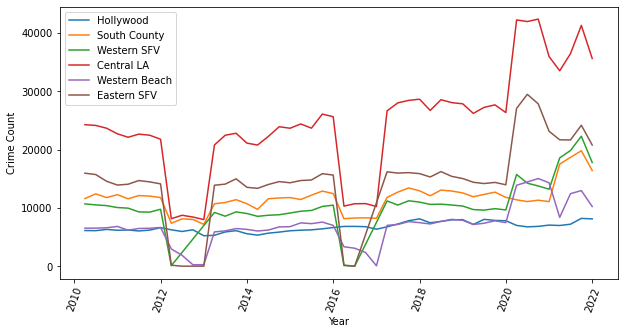

In [15]:
# plot the crime counts corresponding to each of the 21 police departments
pu.plot_area_range(biannual_count_by_area_indexed)

We group the 21 police stations by geographical location and plot the counts. We can see that crime overall is fairly steady. There are dips, mostly evident in the Central LA area, but that area also has the most crime by far.

# How are crimes distributed accross regions in LA county? Annually and by crime type.
Based on the map below (4 cells down, keep scrolling), it's evident that most of the crime occurs in 3 regions San Fernando Valley (top left), Downtown LA (middle), and Long Beach (bottom).
Crime in Downtown LA is consistently more dense with crime, regardless of the crime or year. It's possible that the population is much higher  here and this is why we see much more crime. We will show a distribution below of the most populated areas by region.

In [16]:
# define some lists as options for our widgets to choose from
category_list = list(pu.crime_desc_map.keys())
category_list.sort()
years_list = np.unique(crime_data['DATE OCC'].dt.year.values)

# dropdown object to let us select type of crime
category_widget = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=category_list,
    value=category_list[0],
    description='Crime category:')

# dropdown object to let us select date
year_widget = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=years_list,
    value=years_list[-1],
    description='Year:')

# dropdown object to let us select type of crime
sheriff_widget = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=[True,False],
    value=False,
    description='Show sheriff departments?')

# dropdown object to let us select date
police_widget = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=[True, False],
    description='Show police departments?')

## Plotting crime by category in Los Angeles
Please use the dropdowns below to select a crime category and year to plot.<br>
Police stations are in <font color='blue'>blue</font> with a white outline.<br>
Crime locations (rounded to the nearest block) are in <font color='red'>red</font>.<br>

### Note:
Due to resource restrictions, a random sample is used. The size can be adjusted at the top of the cell above.<br>
Please wait a few seconds between each new crime category.

In [17]:
# don't plot all the data, limit to N_SAMPLES to avoid resource restriction issues
N_SAMPLES = 10000

# show our widgets and plot
i = widgets.interactive(pu.plot_func,
                        category=category_widget, 
                        year=year_widget, 
                        police=police_widget, 
                        sheriff=sheriff_widget,
                        # non widgets need to be in fixed()
                        crime_data=fixed(crime_data),
                        crime_dict=fixed(crime_dict),
                        law_stations=fixed(law_enforcement_df),
                        n_samples=fixed(N_SAMPLES))
display(i)

interactive(children=(Dropdown(description='Crime category:', options=('ANIMAL_CRIME', 'ASSAULT', 'BURGLARY', …

In [18]:
# get general population stats based on area
stats = pop_by_area.agg(['std', 'mean', 'median', 'max', 'min', 'sum']).transpose()
stats = stats.round(0).astype(int)

pop_by_area['Pct of total pop'] = ((pop_by_area/stats['sum'])*100).round(3)
pop_by_area.rename(columns={0:'Population'}, inplace=True)

display(stats.style.format('{:,}'))
display(pop_by_area.head(10).style.format('{:,}'))

,std,mean,median,max,min,sum
0,"25,092","29,000","22,564","151,195",546,"3,711,967"


,Population,Pct of total pop
cityname,,
North Hollywood,"151,195",4.073
Van Nuys,"93,149",2.509
Boyle Heights,"88,520",2.385
Sherman Oaks,"84,818",2.285
Sylmar,"83,778",2.257
Pacoima,"81,334",2.191
Melrose,"78,238",2.108
Panorama City,"76,903",2.072
Reseda,"75,953",2.046


For those not familiar with the San Fernando Valley, 8 of the top cities do show up in the top 10 most populated cities. It would be logical to think that the majority of crime would be in the San Fernando Valley. However, as the map above shows, this isn't usually the case as Downtown seems more crime filled. Unfortunately, this is not an apples to apples comparison.<br>

Downtown LA could be made up of smaller, more dense cities. Thereby, it could have a larger population as a sum of many more smaller cities, while having a smaller population per city. If we look at the percentage of the total LA County population in each, they account for very little each. Therefore, it would be difficult to say whether crime would be more prevalent based on population data.

However, we can conclude that Downtown LA does appear to have more crime across all crime types and years.

### A few caveats:
1. The census data is from 2016 as it's the most recent census data we could find that also includes population by area. Therefore, it is possible the population has disproportionately increased.<br><br>
2. The city census data does not exactly correspond to the LAPD reporting districts. This is because census data follows tracts, which don't exactly correspond to the the same way districts/zip codes are laid out. However, for broad analysis, this should be fine.<br><br>

# Why are there areas of the map with no crime? (North El Monte, Citrus)
It may be surpising to see that there are areas in LA county where there is no crime reported. However, this is due to the fact that not all parts of LA county are under the jurisdiction of the LAPD (the owner of the dataset we are using). In fact: 

"LASD provides general law enforcement services to 42 contract cities"
(https://www.lasd.org/about_us.html)

By default, the graph above hides sheriff stations. But toggling them, shows the missing areas where there are sheriff stations. Note, some areas are under the LASD, but do not have a law enforcement station. While it's not safe to say that the mountains and wildlife areas do not have any crime, they are not under the LASD or LAPD.

In [19]:
# define some lists as options for our widgets to choose from
category_list = list(pu.crime_desc_map.keys())
category_list.sort()
grouping_list = ['Monthly', 'Tri-Annually', 'Bi-Annually', 'Yearly']

category_w = widgets.SelectMultiple(
    style={'description_width': 'initial'},
    options=category_list,
    value=[],
    rows=len(category_list),
    description='Crime types',
    disabled=False
    )

grouping_w = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=grouping_list,
    value=grouping_list[0],
    description='Frequency:')

plot_type_w = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=['Line', 'Hist'],
    value='Line',
    description='Plot type:')

# make sure changes to the widget are shown in the cell that has display(output1)
output1 = widgets.Output()

## Plot crime by count and category
Please select crime types to plot.<br>
Multiple types are possible. Hold CTRL and click as many options desired.<br>
Plot is recalculated after each new item selected. Please be patient for larger datasets or if you select many types.<br>
To avoid scaling issues, it's recommended to group crime types based on other crime types with similar counts.

## Suggested groupings (counts based on 3 month grouped data):
HIGH (>3K): Assault, Burglary, Theft, Vehicle<br>
MEDIUM (1K-3K): Vandalism, Violence, Weapon<br>
LOW (100-1K): Fraud, Minor_underage, Other, Robbery, Sexual_Crime, Stalking, Threats<br>
VERY_LOW (<100): Animal_Crime, Disruption, Homicide, Kidnapping<br>

# What kinds of crimes are increasing/decreasing?

In [20]:
# display our widget
j = widgets.interactive(pu.call_category_plot,
                        categories=category_w, 
                        grouping=grouping_w,
                        plot_type=plot_type_w,
                        # non widgets need to be in fixed()
                        crime_data=fixed(crime_data),
                        crime_dict=fixed(crime_dict),
                        output1=fixed(output1),
                        latest_date=fixed(latest_date))
display(j)
display(output1) # for making sure changes to widget selection get printed here

interactive(children=(SelectMultiple(description='Crime types', options=('ANIMAL_CRIME', 'ASSAULT', 'BURGLARY'…

Output()

Using the graph above, we can see trends of particular crime categories over the last 10-11 years. Perhaps most interesting is the the start of the Coronavirus pandemic (March 2020). If we take a look at these categories in the triannual and biannual lenses, we can see trends. Monthly frequency is too granular and annual is too broad.<br><br>

Here we can see the following crime trends:<br>

Decreasing:
+ Burglary
+ Assault
+ Fraud
+ Minor_underage
+ Robbery
+ Sexual_crime
+ Theft
+ Violent


Increasing:
+ Weapon (related)
+ Homicide
<br><br>

It makes sense that overall crime would be dropping, since people are out less, and that creates less opportunity for most crimes. In particular, burglary is down. Again, as people are home more often, there is less opportunity for burglars to strike.<br><br>

Perhaps most surprising is that weapon related and homicide crimes are up. We can only speculate as to the cause, but perhaps it would have to do with the fact that criminals who commit more serious crimes are less likely to follow coronavirus restrictions. 

In [33]:
# define some lists as options for our widgets to choose from
category_list = list(pu.crime_desc_map.keys())
category_list.sort()
cat_list_all = category_list.copy()
cat_list_all.insert(0, 'ALL Crime') # add an 'ALL Crime' item to category list
years = np.unique(crime_data['DATE OCC YR'].values)
descents = crime_data['Vict Descent'].unique().tolist()

crime_cat_w = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=cat_list_all,
    value=cat_list_all[0],
    description='Crime types'
    )

year_w = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=years,
    value=years[-1],
    description='Year:')

sex_descent_w = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=['Vict Descent', 'Vict Sex'],
    description='Victim Descent or Sex?')

# make sure changes to the widget are shown in the cell that has display(output2)
output2 = widgets.Output()

# Who are the victims of crime in LA County (most recently)?

### By victim descent:
We can see use the violin plot below to see how crime how old victims are within their ethnic groups for 'ALL Crime' in 2021 ONLY (change the value below if you wish to see more).
It seems that victim ages are usually pretty uniform acrosss all ethnic groups between 20-60 years old. A few outliers are Guamanian, Samoan, and Hawaiian groups.<br>

Please note that we split the countplots into 2 sections. One for larger groups and one for smaller groups, to make it easier to see. Taking a look at the countplots below, we can see how many crimes had victims of each group. This tells us which groups had more crimes committed against them. For example, the 'Hispanic/Latino/Mexican' group is about twice as likely to be victims of a crime as the 'Black' group.<br>

It's important to include both of these plot types because the violin plot alone might make it seem as though each group is equally likely to be a victim, when in fact, it's highly skewed towards some groups. This is highly influenced by population (*see below*).

### By victim sex:
We can do the same analysis for sex by changing the last dropdown to 'Vict Sex'. Overall, the age distribution seems to be the same. However, it does seem that males are more likely to be victims under 5 years old. It does seem that males are also more likely to be victims of crimes (at least in 2021 so far). It's possible female victims make up a significant portion of the unknown sex category. However, it's also possible that the remaining category is nonbinary. We can only speculate as to why without more data.

+ M - Male
+ F - Female
+ X - Unknown
+ H - Undefined by the dataset provider (accounts for 0.004% of the data)

## Interactive plot for plotting individual crime types, year, and either descent/sex.

In [35]:
l = widgets.interactive(pu.call_violin_plot,
                        category=crime_cat_w,
                        year=year_w,
                        sex_descent=sex_descent_w,
                        # non widgets need to be in fixed()
                        crime_data=fixed(crime_data),
                        crime_dict=fixed(crime_dict),
                        output2=fixed(output2))
display(l)
display(output2)

interactive(children=(Dropdown(description='Crime types', options=('ALL Crime', 'ANIMAL_CRIME', 'ASSAULT', 'BU…

Output(outputs=({'name': 'stdout', 'text': 'Crunching data. Please be patient.\n', 'output_type': 'stream'}, {…

It's difficult to determine exactly where we draw boundaries based on census data. For example, census data has a question for race and another for ethnicity. Someone could choose to respond as Hispanic/latino and identify as white or not white:

'White alone, not Hispanic or Latino are individuals who responded "No, not Spanish/Hispanic/Latino" and who reported "White" as their only entry in the race question.'<br>
(https://www.census.gov/quickfacts/fact/note/US/RHI825219)

Based on 2019 census data, we can see the following:
+ 70.7% &nbsp; White, only
+ 48.6% &nbsp; Hispanic or Latinos
+ 26.1% &nbsp; White alone, not Hispanic or Latino 
+ 15.4% &nbsp; Asian alone
+ 9.0% &nbsp; &nbsp; Black or African American alone
+ 3.1% &nbsp; &nbsp; Two or more races
+ 1.4% &nbsp; &nbsp; American Indian or Alaska native alone
+ 0.4% &nbsp; &nbsp; Native American or Other Pacific Islander along<br>

(https://www.census.gov/quickfacts/fact/table/losangelescountycalifornia/PST045219#qf-headnote-b)

It would make sense that latinos would be victims or crimes more often as they make up a significant chunk of the population. It is suprising that people of 'White' descent would be lower than latinos. The number of crimes they are victims in comes close (or even exceeds) that of latinos in a few crimes (Fraud, Theft, Vandalism), depending on the year.

In [23]:
# define some lists as options for our widgets to choose from
category_list = list(pu.crime_desc_map.keys())
category_list.sort()
category_list.insert(0, 'ALL CRIME')

cat3_w = widgets.Dropdown(style={'description_width': 'initial'},
                            options=category_list,
                            value=category_list[0],
                            description='Category:')

output4 = widgets.Output()

n = widgets.interactive(pu.time_plotter,
                        cat=cat3_w,
                        # non widgets need to be in fixed()
                        df=fixed(crime_data),
                        output=fixed(output4))
display(n)
display(output4)

interactive(children=(Dropdown(description='Category:', options=('ALL CRIME', 'ANIMAL_CRIME', 'ASSAULT', 'BURG…

Output()

# What is the likelihood of a crime based on the day of the week? By month?

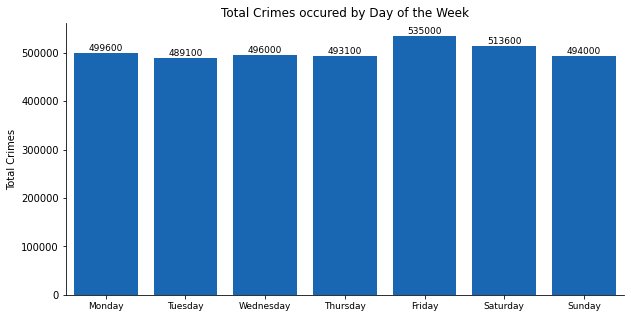

In [24]:
# change this to see different crime type
CRIME_TYPE = 'ALL CRIME' # or 'ASSAULT', 'BURGLARY'

day_occurred = [d.isoweekday() for d in crime_data["DATE OCC"]]
crime_data["Day Occurred"] = np.array(day_occurred)
pu.plot_weekly_crime(crime_data, CRIME_TYPE)

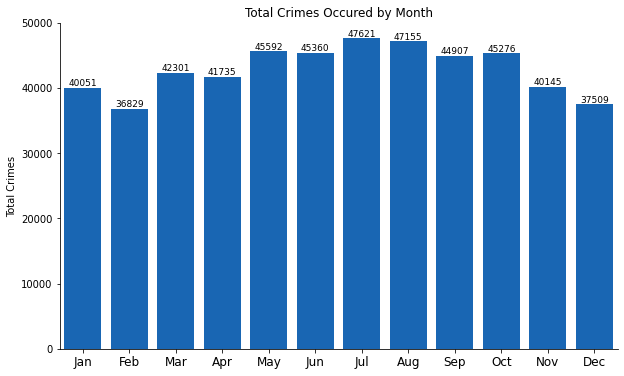

In [25]:
import importlib
importlib.reload(pu)

# change this to see different crime type
CRIME_TYPE = 'ALL CRIME' # or 'ASSAULT', 'BURGLARY'

pu.plot_monthly_crime(crime_data,'ASSAULT')

# Is there any trends in crimes?

In [26]:
monthly_crimes = pd.pivot_table(data=crime_data,
                                values="DR_NO",
                                index = "month_year",
                                columns = "Crime Category",
                                aggfunc='count').fillna(0)
monthly_crimes.columns.name = None
monthly_crimes["All Categories"] = monthly_crimes.apply(sum, axis=1)
monthly_crimes.reset_index(inplace=True)

In [27]:
# define some lists as options for our widgets to choose from
category_list = monthly_crimes.columns.tolist()
category_list.remove('All Categories')
category_list.remove('month_year')
category_list.sort()
category_list.insert(0, 'All Categories')
category_list2 = category_list.copy()
category_list2.insert(0, '')

cat1_w = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=category_list,
    value=category_list[0],
    description='Category 1:')

cat2_w = widgets.Dropdown(
    style={'description_width': 'initial'},
    options=category_list2,
    value='',
    description='Category 2:')

output3 = widgets.Output()

In [28]:
m = widgets.interactive(pu.regplot_plotter,
                        category1=cat1_w,
                        category2=cat2_w,
                        # non widgets need to be in fixed()
                        df=fixed(monthly_crimes),
                        output3=fixed(output3))
display(m)
display(output3)

interactive(children=(Dropdown(description='Category 1:', options=('All Categories', 'ANIMAL_CRIME', 'ASSAULT'…

Output()

We can see some obvious trends. For example: robbery, theft, and burglary all have similar slopes. This makes sense as there may be some overlap between them. It's obvious that others would have no correlation. For example, violent crimes and fraud have differing slopes. However, as the addage goes, correlation does not equal causation.

# What kinds of weapons are the most likely to be used in crimes?

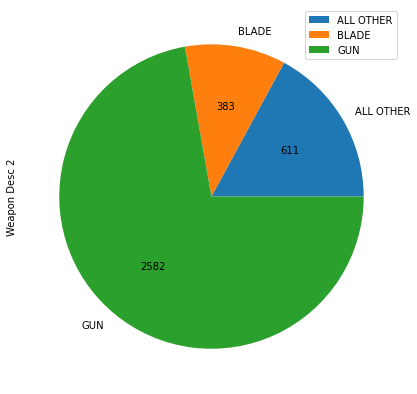

In [29]:
crime_data["Weapon Desc 2"] = crime_data["Weapon Desc"].apply(pu.weapon_desc)
pu.plot_pie(crime_data, 'HOMICIDE', "Weapon Desc 2")

When crimes do have a weapon, it seems the most used weapon is a gun. In fact, close to 3/4 crimes that involve a weapon are with guns. Blades are much less common, accounting for about 10%. Other weapons (including fists and body parts) are the remaining ~13%

# Machine learning

In [30]:
mon_occurred = [d.month for d in crime_data["DATE OCC"]]
year_occurred = [d.year for d in crime_data["DATE OCC"]]

# add some columns to use in our ML model
crime_data["Month Occurred"] = np.array(mon_occurred)
crime_data["Year Occurred"] = np.array(year_occurred)
crime_data['hour'] = crime_data['TIME OCC'].dt.hour
crime_data["vict_age_group"] = crime_data["Vict Age"].apply(pu.age_group)   
crime_data["zone"] = crime_data["AREA NAME"].apply(pu.area_group)
crime_data["premis_cat"] = crime_data["Premis Desc"].apply(pu.premis_category)

# get a subset of the columns for our model
model_data = crime_data[["zone",
                         "vict_age_group",
                         "Vict Sex",
                         "Vict Descent",
                         "Day Occurred",
                         "Month Occurred",
                         "hour",
                         "Crime Category",
                         "premis_cat"]]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # format our data and append them as new columns
    model_data["sex"] = pd.factorize(model_data["Vict Sex"])[0]
    model_data["Descent"] = pd.factorize(model_data["Vict Descent"])[0]
    model_data["crime"] = pd.factorize(model_data["Crime Category"])[0]
    model_data["age"] = pd.factorize(model_data["vict_age_group"])[0]
    
# drop unneeded columns
model_data = model_data[["zone",
                         "age",
                         "sex",
                         "Descent",
                         "Day Occurred",
                         #"Month Occurred",
                         "hour",
                         "crime",
                         "premis_cat"]]
model_data = model_data[:25000] # get a subset of our data

Accuracy:  67.42 %


,Class Name,precision,recall,f1-score,support
0,-1,0.00,0.00,0.00,2
1,0,0.63,0.43,0.51,1966
2,1,0.69,0.84,0.76,2961
3,2,0.52,0.39,0.45,71


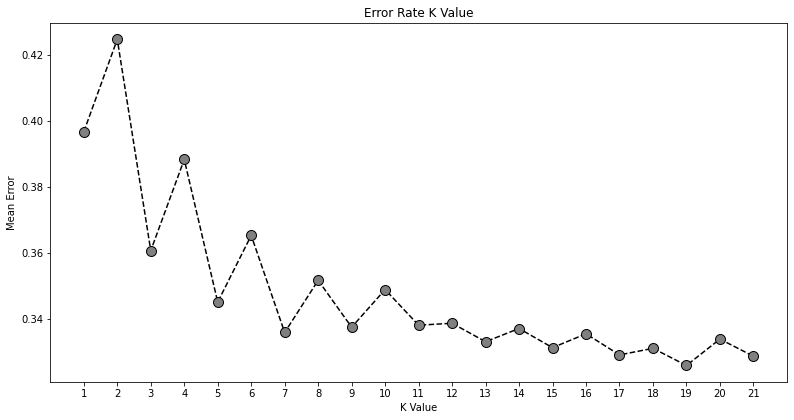

In [31]:
label='sex'
# assign our variables for training
y = model_data[[label]] 
X = model_data.loc[:,~(model_data.columns.isin([label]))]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    _,accuracy_score,report = pu.knn_model(#neighbours=6,
                                            plot_k_values=True, 
                                            plot_confusion_matrix=True,
                                            optimize=True,
                                            neighbours=False,
                                            label=label,
                                            X=X,
                                            y=y)
print('Accuracy: ', accuracy_score, '%')
display(report)

# CONCLUSION AND FUTURE WORK


1- We tried and Build different models for classification and clustering the data based on the following features:
Victim age, sex, descent, premises(house/street/market etc), time of day, day of week, location, and finally the month.

2- The goal of this ML model was to see if we can predict the potentially dangerous area based on these features like time, day, age, premises, sex etc

3- Since the data is Huge i-e 2.7 million rows, that means every kind of crimes occured in every part of LA county in every situation. That means there is a very subtle indicator which makes it harder for a ML model to classify.

4- We were able to find meaningful results that can be improved with some hyper-parameter tuning that is resuose intensive as the data is too big to fine tune with limited resourses. Some other features can be added like the population density per location and median income from City website, That alongwith neural network models will certainly improve the overall accuracy.
